# Fitting old pipelines to new data

In this brief notebook, you'll see how to load a saved pipeline and fit it to raw data again.  This is a very useful way to retrain a classifier to new data (which you might do after observing data drift) or to change the hyperparameters you used while training the classifier.  

Machine learning pipelines work in two ways:  for training, they allow you to precisely specify a sequence of steps (data cleaning, feature extraction, dimensionality reduction, model training, etc.) that start with raw data and result in a model, trying this sequence with different hyperparameters.  For production, they allow you to reuse the exact sequence of steps that were used in training a model to make predictions from new raw data. 

We'll start by loading training and testing data:

In [1]:
import pandas as pd
from sklearn import model_selection
df = pd.read_parquet("data/training.parquet")

# X_train and X_test are lists of strings, each 
# representing one document
# y_train and y_test are vectors of labels

train, test = model_selection.train_test_split(df, random_state=43)
X_train = train["text"]
y_train = train["label"]

X_test = test["text"]
y_test = test["label"]

Next up, we'll load the two steps of the pipeline that we created in earlier notebooks:

- `feature_pipeline.sav` from either the [simple summaries notebook](03-feature-engineering-summaries.ipynb) or the [TF-IDF notebook](03-feature-engineering-tfidf.ipynb), and
- `model.sav` from either the [logistic regression notebook](04-model-logistic-regression.ipynb) or the [random forest notebook](04-model-random-forest.ipynb).

(If you haven't worked through at a feature engineering notebook and a model training notebook, the next cell won't work.)

In [2]:
## loading in feature extraction pipeline
import pickle
filename = 'feature_pipeline.sav'
feat_pipeline = pickle.load(open(filename, 'rb'))

## loading model
filename = 'model.sav'
model = pickle.load(open(filename, 'rb'))

Now we can combine the two stages together in a pipeline and fit it to new training data.  (Note that the feature extraction pipeline stage, `feature_pipeline.sav`, is _itself_ a pipeline!)

In [3]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('features',feat_pipeline),
    ('model',model)
])

A pipeline supports the same interface as a classifier, so we can use it to `fit` to raw data and then `predict` labels from raw data:

In [7]:
pipeline.fit(X_train,y_train)
y_preds = pipeline.predict(X_test)

We can then evaluate the performance of our classifier, using a confusion matrix:

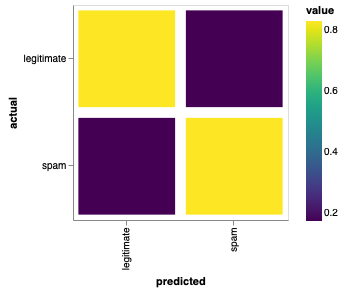

In [11]:
from mlworkflows import plot
df, chart = plot.binary_confusion_matrix(y_preds, y_test)
chart

...or an F<sub>1</sub>-score:

In [9]:
from sklearn.metrics import f1_score
# calculate f1 score
mean_f1 = f1_score(y_test, y_preds, average='micro')
print(mean_f1)

0.8287


The [scikit-learn pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline) doesn't just make a particular pipeline repeatable; it also lets you run repeatable experiments by evaluating the same pipeline with different hyperparameters for the same data set.  To see this in action, we'll inspect the pipeline stages to see their hyperparameters:

In [15]:
pipeline.named_steps

{'features': Pipeline(memory=None,
      steps=[('features', <mlworkflows.featuressimple.SimpleSummaries object at 0x7fa56c495240>)]),
 'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=4000, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
           tol=0.0001, verbose=0, warm_start=False)}

Let's experiment with a couple of different options for a hyperparameter.  Since we have no way of knowing while we're writing this notebook whether you trained a logistic regression model or a random forest model, this notebook will try and figure it out on the fly (since these model types have different hyperparameters).  The [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) class in scikit-learn allows us to evaluate different combinations of hyperparameters; we'll use it with just a few options to quickly demonstrate its functionality.

In [ ]:
from sklearn.model_selection import GridSearchCV

search = None

if 'LogisticRegression' in str(pipeline.named_steps['model']):
    param_grid = { 'model__multi_class' : ['ovr', 'multinomial'], 'model__solver' : ['lbfgs', 'saga']}
    search = GridSearchCV(pipeline, param_grid, iid=False, cv=5, return_train_score=False)
    search.fit(X_train, y_train)
    
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

AttributeError: 'Pipeline' object has no attribute 'reset'